In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('salary_data.csv')

Software thì ta quan tâm nhóm có băng high school nữa

#### Preprocessing
- Drop na
- Standardize education, gender cols
- Rename cols for easier work

In [22]:
data.rename(columns={
    'Age': 'age',
    'Gender': 'gender',
    'Education Level': 'edu', 
    'Job Title': 'job',
    'Years of Experience':'exp', 
    'Salary': 'salary'}, inplace=True)
data.dropna(inplace=True)
#normalize job titles and education levels
data['gender'] = data['gender'].str.lower().str.strip()
data['job'] = data['job'].str.lower().str.strip()
data['edu'] = data['edu'].str.lower().str.strip()
data['edu'].replace(
    {"bachelor's": "bachelor", 
     "master's": "master", 
     "bachelor's degree": "bachelor",
     "master's degree": "master"}, 
inplace=True)

#### Define Functions

In [23]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def anova_pairwise_tukeyhsd(df, col1, col2):
    fig = plt.figure(figsize=(4, 2))
    ax1 = fig.add_subplot(1, 1, 1)
    sns.boxplot(x=col1, y=col2, data=df, palette="Set3", ax=ax1)
    plt.show()

    model = ols(f'{col2} ~ C({col1})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)
    print('\n')
    m_comp = pairwise_tukeyhsd(endog=df[col2], groups=df[col1], alpha=0.05)
    print(m_comp)

In [24]:
from scipy.stats import chi2_contingency, chi2
def plot_crosstab_and_show_dependency(df, col1, col2):
    crosstab = pd.crosstab(df[col1], df[col2])
    crosstab.plot(kind='bar', stacked=True, figsize=(5, 3))
    plt.title(f'{col1} vs {col2}')
    plt.show()

    stat, p, dof, expected =chi2_contingency(crosstab)
    print(f'p-value: {p}')
    print(f'dof: {dof}')

    prob = 0.975
    critical = chi2.ppf(prob, dof)
    print(f'probability: {prob}, critical: {critical}, stat: {stat}')

    alpha = 1 - prob
    print(f'alpha (significant): {alpha}, p-value: {p}')
    if p <= alpha:
        print(f'{col1} dependent {col2} (reject H0)')
    else:
        print(f'{col1} independent {col2}(fail to reject H0)')

In [25]:
def num_univariate_analysis(data, col: str):
    #Descriptive statistics
    print(data[col].describe(include='all'))
    col_median = data[col].median()
    col_mode = data[col].mode().iloc[0]
    col_range = data[col].max() - data[col].min()
    col_variance = data[col].var()
    col_skew = data[col].skew()
    col_kurt = data[col].kurt()

    print(f"Median {col_median}")
    print(f"Mode {col_mode}")
    print(f"Range {col_range}")
    print(f"Var {col_variance}")
    print("****************************************************")

    # Histogram
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(data[col], kde=True)
    plt.subplot(1, 3, 2)
    plt.hist(data[col])
    plt.subplot(1, 3, 3)
    plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
    plt.show()
    print(f"Skew {col_skew}")
    print(f"Kurt {col_kurt}")
    if col_skew > 0:
        print("Phân phối lệch phải")
    else:
        print("Phân phối lệch trái")
    
    if col_kurt > 0:
        print("Phân phối nhọn hơn phân phối chuẩn")
    else:
        print("Phân phối có độ nhọn thấp hơn phân phối chuẩn")
    print("****************************************************")

    col_Q1 = data[col].quantile(0.25)
    col_Q3 = data[col].quantile(0.75)
    col_IQR = col_Q3 - col_Q1
    print(f"Q1 - Q3: {col_Q1} - {col_Q3}")
    print(f"IQR {col_IQR}")

    # Boxplot, Outliers
    plt.figure(figsize=(2,2))
    plt.boxplot(data[col])
    plt.show()
    col_outliers_upper_num = data[data[col] > (col_Q3 + 1.5*col_IQR)].shape[0]
    col_outliers_lower_num = data[data[col] < (col_Q1 - 1.5*col_IQR)].shape[0]
    col_outliers_per = (col_outliers_upper_num + col_outliers_lower_num)/data.shape[0] * 100
    print(f"Number of outliers: {col_outliers_upper_num + col_outliers_lower_num}")
    print(f"Number of upper outliers: {col_outliers_upper_num}")
    print(f"Number of lower outliers: {col_outliers_lower_num}")
    print(f"Percentage of outliers: {col_outliers_per}%")
    # vì outlier có tỉ lệ nhỏ (<1%) nên có thể không cần loại bỏ outlier

In [26]:
class PlotType(enumerate):
    HIST = 'hist'
    PIE = 'pie'
    BAR = 'bar'

def cat_univariate_analysis(data:pd.DataFrame, fig_size=(10, 5), exclude_cols=[], num_cols=3, plot_type=PlotType.HIST):
    i = 0
    category_cols = [col for col in data.columns if data[col].dtype == 'object']
    num_rows = len(category_cols) // num_cols + 1
    fig = plt.figure(figsize=fig_size)
    for col in category_cols:
        if col in exclude_cols:
            continue
        i += 1
        fig.add_subplot(num_rows, num_cols, i)
        if plot_type == PlotType.HIST:
            sns.histplot(data[col])
        elif plot_type == PlotType.PIE:
            plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
        elif plot_type == PlotType.BAR:
            sns.barplot(x=data[col].value_counts().index, y=data[col].value_counts())
        plt.xticks(rotation=90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

In [27]:
numbers_cols = [col for col in data.columns if data[col].dtype != 'object']
description = data.describe()
modes = data.mode().iloc[0] # (1,33)
description.loc['mode'] = modes
description.loc['var'] = data[numbers_cols].var()
standard_error = data[numbers_cols].sem()
description.loc['std'] = standard_error
kurtosis = data[numbers_cols].kurtosis()
description.loc['kur'] = kurtosis
skewness = data[numbers_cols].skew()
description.loc['skew'] = skewness
range = data[numbers_cols].max() - data[numbers_cols].min()
description.loc['range'] = range
description

,age,exp,salary
count,6698.000000,6698.000000,6.698000e+03
mean,33.623022,8.095178,1.153293e+05
std,0.093056,0.074049,6.450262e+02
min,21.000000,0.000000,3.500000e+02
25%,28.000000,3.000000,7.000000e+04
50%,32.000000,7.000000,1.150000e+05
75%,38.000000,12.000000,1.600000e+05
max,62.000000,34.000000,2.500000e+05
mode,27.000000,2.000000,1.400000e+05
var,58.000169,36.727128,2.786762e+09


#### Drill to software jobs only

In [28]:
# get values contain Data
data_jobs = data['job'].value_counts().index
data_keywords = ['data', 'analyst']
data_jobs = [job for job in data_jobs if any(keyword in job for keyword in data_keywords)]

remove_jobs = ['data entry clerk', 'help desk analyst']
data_jobs = [job for job in data_jobs if job not in remove_jobs]

software_jobs = data['job'].value_counts().index
software_keywords = [
    'software', 'engineer', 
    'developer', 'programmer', 
    'mobile', 'full stack', 
    'front end', 'back end', 'web']
remove_jobs = ['software project manager', 'network engineer', 'project engineer', 'junior web designer', 'senior data engineer']
software_jobs = [job for job in software_jobs if any(keyword in job for keyword in software_keywords)]
software_jobs = [job for job in software_jobs if job not in remove_jobs]

data['job_type'] = data['job'].apply(lambda x: 'data' if x in data_jobs else ('software' if x in software_jobs else 'other'))

In [29]:
df_software = data[data['job_type'] == 'software']

def get_level(job):
    if 'junior' in job:
        return 'junior'
    elif 'principle' in job or 'director' in job or 'architect' in job:
        return 'vip'
    elif 'senior' in job:
        return 'senior'
    else:
        return 'no-level'
df_software['level'] = df_software['job'].apply(lambda x: get_level(x))

C:\Users\PC\AppData\Local\Temp\ipykernel_19280\1255946145.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_software['level'] = df_software['job'].apply(lambda x: get_level(x))


#### Number Univariate analysis
- Về exp, mức phổ biến là từ 3 - 13 năm, từ 10 exp tỉ lệ giảm, và trên 20 tỉ lệ này còn thấp hơn => phân phối lệch phải mạnh, ngoại lai là > 27 và có 41 ngoại lai (làm việc nhiều hơn 27 năm), chiếm 1.5%. Median là 6, mean là 8 (rất giống khi xét tổng thể nhưng cần t test)
- Về age, phổ biến là khoảng 27 - 42 tuổi, ngoài khoảng này ra thì tỉ lệ các nhóm tuổi còn lại khá thấp, đa phần đều là những người nằm trong độ tuổi vàng lao động (22 - 40), mode(xuất hiện nhiều nhất) là 27, mean là 34, Median là 31 (rất giống khi xét tổng thể nhưng cần t test)
- Range salary phổ biến từ 75000$ - 170000$, mode là 80000$, median và mean là 122354$, 121310$. Phân phối lệch trái ( khác so với tổng thể), không có ngoại lại

count    2654.000000
mean        8.612660
std         6.974614
min         0.000000
25%         3.000000
50%         6.000000
75%        13.000000
max        34.000000
Name: exp, dtype: float64
Median 6.0
Mode 4.0
Range 34.0
Var 48.6452373235742
****************************************************


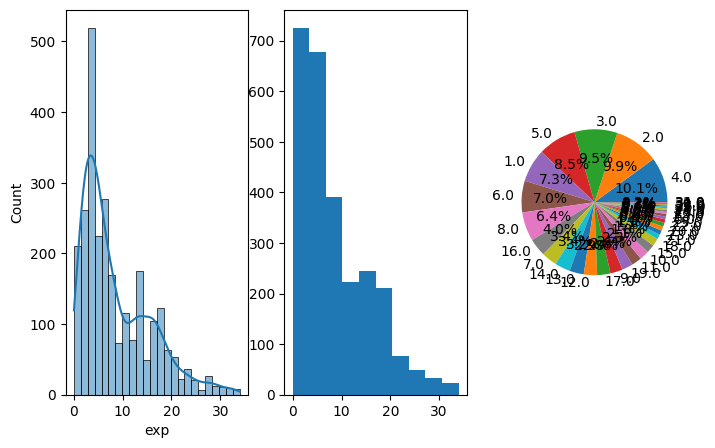

Skew 1.126723239844443
Kurt 0.71956784955665
Phân phối lệch phải
Phân phối nhọn hơn phân phối chuẩn
****************************************************
Q1 - Q3: 3.0 - 13.0
IQR 10.0


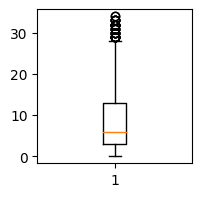

Number of outliers: 41
Number of upper outliers: 41
Number of lower outliers: 0
Percentage of outliers: 1.544837980406933%


In [30]:
num_univariate_analysis(df_software, 'exp')
# num_univariate_analysis(df_software, 'age')
# num_univariate_analysis(df_software, 'salary')

#### Category Univariate Analysis
Trong tập dữ liệu:
- Nữ chiếm 38.4%, nam chiếm 61.1%, khác chiếm 0.5%
- Bằng cấp 3 chiếm 1.5%. Bằng Cứ nhân chiếm 51%, bằng thạc sĩ chiếm 28%, bằng tiến sĩ chiếm 18% (bằng tiến sĩ cao hơn cả bằng thạc sĩ)
- Xét 100% nhóm các ngành thuộc ngách software
- Ta xem xét thêm yếu tố level trong job title, 73% ko có level, 5.7 là junior, 21.4 là senior, và chỉ 0.1 là vip

In [31]:
category_cols = [col for col in df_software.columns if df_software[col].dtype == 'object']
for col in category_cols:
    print(f"{col} have {df_software[col].nunique()} unique values: {df_software[col].unique()}")

gender have 3 unique values: ['male' 'female' 'other']
edu have 4 unique values: ['bachelor' 'master' 'phd' 'high school']
job have 19 unique values: ['software engineer' 'software developer' 'senior engineer'
 'software manager' 'junior developer' 'web developer'
 'senior software engineer' 'junior software developer'
 'junior web developer' 'principal engineer' 'senior software developer'
 'junior software engineer' 'senior software architect'
 'director of engineering' 'software engineer manager'
 'back end developer' 'senior project engineer' 'full stack engineer'
 'front end developer']
job_type have 1 unique values: ['software']
level have 4 unique values: ['no-level' 'senior' 'junior' 'vip']


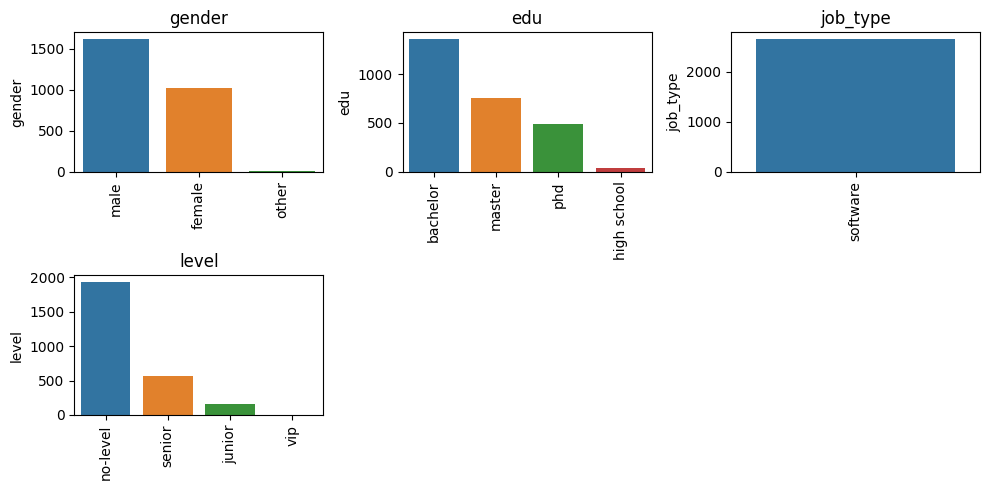

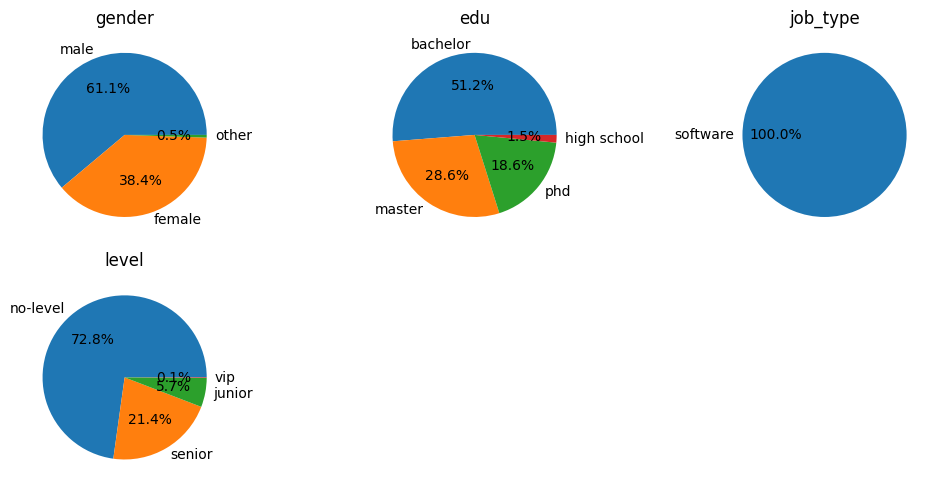

In [32]:
cat_univariate_analysis(df_software, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.BAR)
cat_univariate_analysis(df_software, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.PIE)

#### Number vs Number Multivariate Analysis
Dựa vào correlation matrix, Ta thấy exp và age tương quan mạnh, điều này là dễ hiểu, vì càng làm lâu thì tuổi càng lớn, có một số người thì bắt đầu sự nghiệp muộn. Salary tương quan mạnh với exp hơn là với age. Trong nhóm software, ta thấy salary tương quan  mạnh với age và exp 0.824 và 0.813

Theo T-test hypothesis test
- no level giống mid hơn là một cấp độ tương đương junior

In [33]:
df_software.corr()

C:\Users\PC\AppData\Local\Temp\ipykernel_19280\3361161729.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_software.corr()


,age,exp,salary
age,1.000000,0.935368,0.824529
exp,0.935368,1.000000,0.813566
salary,0.824529,0.813566,1.000000


In [34]:
df_software_junior = df_software[df_software['level'] == 'junior']
df_software_senior = df_software[df_software['level'] == 'senior']
df_software_vip = df_software[df_software['level'] == 'vip']
df_software_no_level = df_software[df_software['level'] == 'no-level']
from scipy.stats import ttest_ind
print(f'junior software salary: {df_software_junior["salary"].mean()} vs no level software salary: {df_software_no_level["salary"].mean()}')
print(ttest_ind(df_software_junior['salary'], df_software_no_level['salary']))
# đây là phép so sánh không tốt vì có quá nhiều dữ liệu, quá nhiều ngành không có level, 
# khiến lương của những người ko có level trở nên quá cao
print('****************************************************')
print('****************************************************')
print(f'junior software salary: {df_software_junior["salary"].mean()} vs senior software salary: {df_software_senior["salary"].mean()}')
print(ttest_ind(df_software_junior['salary'], df_software_senior['salary']))
print(f'junior software age: {df_software_junior["age"].mean()} vs senior software age: {df_software_senior["age"].mean()}')
print(ttest_ind(df_software_junior['age'], df_software_senior['age']))
print(f'junior software exp: {df_software_junior["exp"].mean()} vs senior software exp: {df_software_senior["exp"].mean()}')
print(ttest_ind(df_software_junior['exp'], df_software_senior['exp']))
print('****************************************************')
print('****************************************************')
print(f'senior software salary: {df_software_senior["salary"].mean()} vs vip software salary: {df_software_vip["salary"].mean()}')
print(ttest_ind(df_software_senior['salary'], df_software_vip['salary']))
print(f'senior software age: {df_software_senior["age"].mean()} vs vip software age: {df_software_vip["age"].mean()}')
print(ttest_ind(df_software_senior['age'], df_software_vip['age']))
print(f'senior software exp: {df_software_senior["exp"].mean()} vs vip software exp: {df_software_vip["exp"].mean()}')
print(ttest_ind(df_software_senior['exp'], df_software_vip['exp']))

junior software salary: 43473.68421052631 vs no level software salary: 116188.56262939959
Ttest_indResult(statistic=-18.882197722260607, pvalue=1.5691366777264757e-73)
****************************************************
****************************************************
junior software salary: 43473.68421052631 vs senior software salary: 159423.6049382716
Ttest_indResult(statistic=-42.18588467163175, pvalue=1.9872988951254908e-196)
junior software age: 27.032894736842106 vs senior software age: 41.3668430335097
Ttest_indResult(statistic=-24.69880939107407, pvalue=6.206104894858942e-98)
junior software exp: 1.6513157894736843 vs senior software exp: 14.17989417989418
Ttest_indResult(statistic=-24.70992344412401, pvalue=5.349342890694574e-98)
****************************************************
****************************************************
senior software salary: 159423.6049382716 vs vip software salary: 160000.0
Ttest_indResult(statistic=-0.029578010436950675, pvalue=0.9764139

##### So sanh 3 vị trí frontend , backend và fullstack
- Frontend, lương trung bình là 83848$
- Backend, lương trung bình là 102352$
- Fullstack, lương trung bình là 126719$
Lương còn tùy thuộc vào kình nghiệm, nhưng ta thấy rõ với mỗi vị trí này chênh lệch là 15000$ và 25000$, và kiểm định t-test cho thấy kết quả có y nghĩa thống kê rất mạnh

- Frontend, age trung bình là 29
- Backend, lương trung bình là 31
- Fullstack, lương trung bình là 34

kiểm định t-test cho thấy kết quả có y nghĩa thống kê rất mạnh

- Frontend, exp trung bình là 4
- Backend, exp trung bình là 6
- Fullstack, exp trung bình là 9


In [35]:
df_front_end = df_software[df_software['job'].str.contains('front end')]
df_back_end = df_software[df_software['job'].str.contains('back end')]
df_full_stack = df_software[df_software['job'].str.contains('full stack')]

print(f"""
    frontend mean salary: {df_front_end["salary"].mean()}
    backend mean salary: {df_back_end["salary"].mean()}
    fullstack mean salary: {df_full_stack["salary"].mean()}
""")
print(ttest_ind(df_front_end['salary'], df_back_end['salary']))
print(ttest_ind(df_front_end['salary'], df_full_stack['salary']))
print(ttest_ind(df_back_end['salary'], df_full_stack['salary']))
print('****************************************************')
print('****************************************************')
print(f"""
    frontend mean age: {df_front_end["age"].mean()}
    backend mean age: {df_back_end["age"].mean()}
    fullstack mean age: {df_full_stack["age"].mean()}
""")
print(ttest_ind(df_front_end['age'], df_back_end['age']))
print(ttest_ind(df_front_end['age'], df_full_stack['age']))
print(ttest_ind(df_back_end['age'], df_full_stack['age']))
print('****************************************************')
print('****************************************************')
print(f"""
    frontend mean exp: {df_front_end["exp"].mean()}
    backend mean exp: {df_back_end["exp"].mean()}
    fullstack mean exp: {df_full_stack["exp"].mean()}
""")
print(ttest_ind(df_front_end['exp'], df_back_end['exp']))
print(ttest_ind(df_front_end['exp'], df_full_stack['exp']))
print(ttest_ind(df_back_end['exp'], df_full_stack['exp']))


    frontend mean salary: 83848.35294117648
    backend mean salary: 102352.56147540984
    fullstack mean salary: 126719.84090909091

Ttest_indResult(statistic=-7.281347172085055, pvalue=1.2478248248007153e-12)
Ttest_indResult(statistic=-18.71892920183277, pvalue=1.7908885724382848e-61)
Ttest_indResult(statistic=-9.378011159760774, pvalue=1.741853247652948e-19)
****************************************************
****************************************************

    frontend mean age: 28.889705882352942
    backend mean age: 30.934426229508198
    fullstack mean age: 34.03896103896104

Ttest_indResult(statistic=-4.608616442801869, pvalue=5.1194196601364225e-06)
Ttest_indResult(statistic=-11.11244795910033, pvalue=3.909433195006988e-26)
Ttest_indResult(statistic=-5.694175221081195, pvalue=2.0198341912316827e-08)
****************************************************
****************************************************

    frontend mean exp: 4.106617647058823
    backend mean exp: 6

No level **giống mid giữa senior và junior hơn là tương đương với junior**

##### So sanh 2 title web, software
web vs software
- salary web: 60000$ vs salary software 56543$
- age web: 30 vs age software 27
- exp web: 3.6 vs exp software 2.8

In [36]:
df_web_dev = df_software[df_software['job'].str.contains('web developer')]
df_software_dev = df_software[df_software['job'].str.contains('software developer')]

print(f"""
    web dev mean salary: {df_web_dev["salary"].mean()}
    software dev mean salary: {df_software_dev["salary"].mean()}
""")
print(ttest_ind(df_web_dev['salary'], df_software_dev['salary']))
print('****************************************************')
print('****************************************************')
print(f"""
    web dev mean age: {df_web_dev["age"].mean()}
    software dev mean age: {df_software_dev["age"].mean()}
""")
print(ttest_ind(df_web_dev['age'], df_software_dev['age']))
print('****************************************************')
print('****************************************************')
print(f"""
    web dev mean exp: {df_web_dev["exp"].mean()}
    software dev mean exp: {df_software_dev["exp"].mean()}
""")
print(ttest_ind(df_web_dev['exp'], df_software_dev['exp']))


    web dev mean salary: 59705.426356589145
    software dev mean salary: 56543.01075268817

Ttest_indResult(statistic=1.5677013330192484, pvalue=0.1179612323148454)
****************************************************
****************************************************

    web dev mean age: 29.914728682170544
    software dev mean age: 26.967741935483872

Ttest_indResult(statistic=7.850282109530027, pvalue=6.65947009450831e-14)
****************************************************
****************************************************

    web dev mean exp: 3.6744186046511627
    software dev mean exp: 2.8333333333333335

Ttest_indResult(statistic=3.652644545543001, pvalue=0.0003041747872152442)


##### So sanh 3 title developer và engineer vs manager
- Kinh nghiệm và tuổi của engineer cao hơn web, nhưng kém manager (36 vs 27y vs 45) và (10 vs 3 yexp và 16yexp)
- lương thì engineer cũng cao hơn web 137000$ vs 56000$ nhưng đều kém cấp quản lý (171000$)
Và tất cả đều có ý nghĩa thống kê

In [37]:
df_software_dev = df_software[df_software['job'].str.contains('software developer')]
df_software_engineer = df_software[df_software['job'].str.contains('software engineer')]
df_software_manager = df_software[df_software['job'].str.contains('software manager') | df_software['job'].str.contains('software engineer manager')]
print(f"""
    software engineer mean salary: {df_software_engineer["salary"].mean()}
    software dev mean salary: {df_software_dev["salary"].mean()}
    software manager mean salary: {df_software_manager["salary"].mean()}
""")
print(ttest_ind(df_software_dev['salary'], df_software_engineer['salary']))
print(ttest_ind(df_software_dev['salary'], df_software_manager['salary']))
print(ttest_ind(df_software_engineer['salary'], df_software_manager['salary']))
print('****************************************************')
print('****************************************************')
print(f"""
    software engineer mean age: {df_software_engineer["age"].mean()}
    software dev mean age: {df_software_dev["age"].mean()}
    software manager mean age: {df_software_manager["age"].mean()}
""")
print(ttest_ind(df_software_engineer['age'], df_software_dev['age']))
print(ttest_ind(df_software_engineer['age'], df_software_manager['age']))
print(ttest_ind(df_software_dev['age'], df_software_manager['age']))
print('****************************************************')
print('****************************************************')
print(f"""
    software engineer mean exp: {df_software_engineer["exp"].mean()}
    software dev mean exp: {df_software_dev["exp"].mean()}
    software manager mean exp: {df_software_manager["exp"].mean()}
""")
print(ttest_ind(df_software_engineer['exp'], df_software_dev['exp']))
print(ttest_ind(df_software_engineer['exp'], df_software_manager['exp']))
print(ttest_ind(df_software_dev['exp'], df_software_manager['exp']))


    software engineer mean salary: 137101.36837678723
    software dev mean salary: 56543.01075268817
    software manager mean salary: 172336.37931034484

Ttest_indResult(statistic=-22.003969377969153, pvalue=3.693771135200723e-92)
Ttest_indResult(statistic=-49.67116041823859, pvalue=1.5220251832646999e-207)
Ttest_indResult(statistic=-13.145734427180596, pvalue=1.6223105228527443e-37)
****************************************************
****************************************************

    software engineer mean age: 36.11606391925988
    software dev mean age: 26.967741935483872
    software manager mean age: 45.718832891246684

Ttest_indResult(statistic=12.633687400827217, pvalue=1.0802322406683664e-34)
Ttest_indResult(statistic=-17.119682633815582, pvalue=2.3504813122343622e-60)
Ttest_indResult(statistic=-29.895741398415534, pvalue=3.5815047297709567e-118)
****************************************************
****************************************************

    software en

#### Category vs Category Multivariate Analysis
Dựa vào chi2 dependency hypothesis testing, ta kết luận
- Trình độ học vấn có phụ thuộc vào gender, hãy xem xét kĩ hơn với phân tích anova
- Trong ngành *software, số người chỉ có bằng cấp 3 rất ít*, càng lên level cao, tỉ trọng của những người có bằng phd và master ngày càng tăng

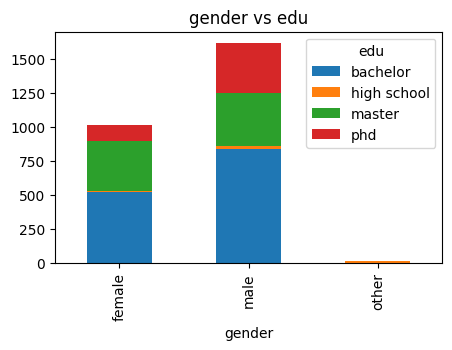

p-value: 1.885464627543726e-158
dof: 6
probability: 0.975, critical: 14.44937533544792, stat: 748.6735554546152
alpha (significant): 0.025000000000000022, p-value: 1.885464627543726e-158
gender dependent edu (reject H0)


In [38]:
plot_crosstab_and_show_dependency(df_software, 'gender', 'edu')

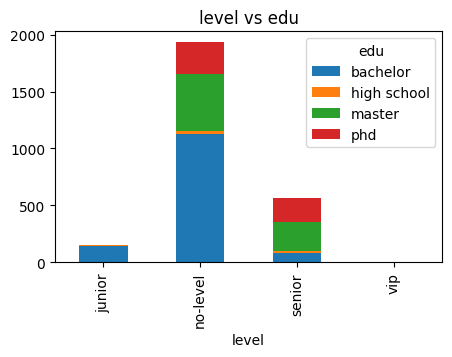

p-value: 9.206490717574079e-101
dof: 9
probability: 0.975, critical: 19.02276779864163, stat: 494.37432278012244
alpha (significant): 0.025000000000000022, p-value: 9.206490717574079e-101
level dependent edu (reject H0)


In [39]:
plot_crosstab_and_show_dependency(df_software, 'level', 'edu')

#### TODO Tuổi bắt đầu ngành có liên quan tới lương không

#### Category vs Number Multivariate Analysis
- Trình độ giáo dục càng cao thì mức lương, tuổi cũng càng lớn (xem cụ thể trong anova table), hs - bachelor - master - phd, mức chênh lll 6000$(ko thể bác bỏ H0 có thể vì tỉ trọng quá nhỏ), 32000$, 52000$. Có kết luận khác có ý nghĩa thống kê là hs level kém master level khoảng 39000$
- Về tuổi, cấp bachelor vs master, chênh lệch tuổi là 5 năm, cấp phd và master chênh khoảng 12 năm, cấp high school lớn hơn bachelor khoảng 2 năm (nhưng ko có ý nghĩa thống kê). High school kém master khoảng 3 năm => người đó có thể có bằng master vào năm 27 tuổi, có thể có bằng phd vào khoảng 39 tuổi.
- Về kinh nghiệm, kình nghiệm của nhóm có bằng bachelor thấp hơn high school và master khoảng 4 năm, master và hs kém phd khoảng 6.7 và 7.2 năm kinh nghiệm => đi làm khoảng 2 năm kinh nghiệm thì người đó mới lấy bằng master (vì bằng master là 2 năm)

- Lương nam giới cao hơn nữ giới 20000$, nam giới cao hơn nữ khoảng 3 tuổi, giới tính 3 cao hơn nữ giới khoảng 7 tuổi
- Kinh nghiệm nam giới cao hơn nữ khoảng 1.6 năm, kinh nghiệm giới tính thứ 3 cao hơn nữ khoảng 9 năm
- Trình đọ học vấn của nam sẽ cao hơn nữ khoảng 0.1 điểm, trình độ học vấn của người thuộc giới tính thứ 3 thường sẽ thấp hơn cả nam và nữ 1.3 điểm (công với việc age của giới tính thứ 3 khá cao) => khả năng người thuộc giới tính thứ 3 không học các cấp bậc học cao hơn rất lớn
- Người học high school sẽ có level cao hơn học bachelor 0.32 nhưng có thể vì họ bắt đầu sự nghiệp sớm hơn (xem lại kết luận về kinh nghiệm ). bằng master cao hơn bachelor 0.38 điểm, phd cao hơn master 0.1 điểm
- **Causuality Inference: liệu người có bằng cao thì gây ra việc họ có lương cao hơn hay người có lương cao hơn thường có bằng cao?**

- Nam sẽ có level cao hơn nữ khoảng 0.1 điểm, giới tính thứ 3 có level cao hơn nữ tới 0.32 điểm

In [ ]:
anova_pairwise_tukeyhsd(df_software, 'edu', 'salary')
anova_pairwise_tukeyhsd(df_software, 'edu', 'age')
anova_pairwise_tukeyhsd(df_software, 'edu', 'exp')

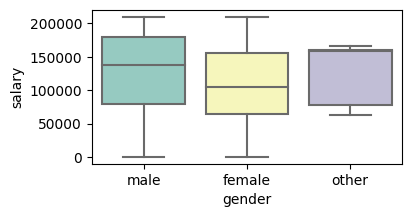

                 sum_sq      df          F        PR(>F)
C(gender)  2.548584e+11     2.0  51.658337  9.799586e-23
Residual   6.539405e+12  2651.0        NaN           NaN


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
female   male 20174.4945    0.0  15517.4165 24831.5726   True
female  other 16978.8424 0.4121 -14362.1546 48319.8394  False
  male  other -3195.6521 0.9688 -34457.3868 28066.0826  False
-------------------------------------------------------------


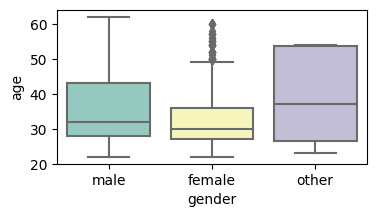

                  sum_sq      df          F        PR(>F)
C(gender)    5708.213239     2.0  36.920491  1.530676e-16
Residual   204933.262647  2651.0        NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
female   male   2.9235    0.0  2.0991   3.748   True
female  other   6.8976   0.01  1.3494 12.4457   True
  male  other    3.974 0.2115 -1.5601  9.5082  False
----------------------------------------------------


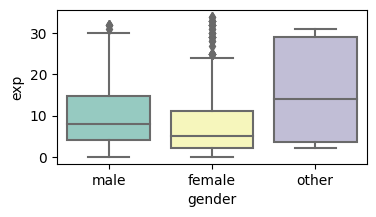

                  sum_sq      df         F        PR(>F)
C(gender)    2634.246871     2.0  27.61945  1.343648e-12
Residual   126421.567748  2651.0       NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
female   male   1.6844    0.0 1.0368  2.3319   True
female  other   8.8922    0.0 4.5346 13.2499   True
  male  other   7.2079 0.0003 2.8612 11.5545   True
---------------------------------------------------


In [41]:
anova_pairwise_tukeyhsd(df_software, 'gender', 'salary')
anova_pairwise_tukeyhsd(df_software, 'gender', 'age')
anova_pairwise_tukeyhsd(df_software, 'gender', 'exp')

C:\Users\PC\AppData\Local\Temp\ipykernel_19280\2940060735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_software['edu_num'] = df_software['edu'].replace({


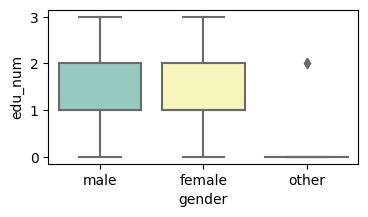

                sum_sq      df          F        PR(>F)
C(gender)    32.594838     2.0  26.276727  5.009606e-12
Residual   1644.209985  2651.0        NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
female   male   0.1031 0.0031  0.0292  0.1769   True
female  other  -1.3017    0.0 -1.7987 -0.8048   True
  male  other  -1.4048    0.0 -1.9005 -0.9091   True
----------------------------------------------------


In [42]:
df_software['edu_num'] = df_software['edu'].replace({
    'high school': 0, 
    'bachelor': 1, 
    'master': 2, 
    'phd': 3})
anova_pairwise_tukeyhsd(df_software, 'gender', 'edu_num')

C:\Users\PC\AppData\Local\Temp\ipykernel_19280\64492171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_software['level_num'] = df_software['level'].replace({


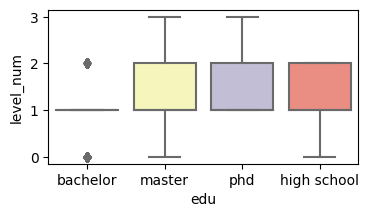

              sum_sq      df           F         PR(>F)
C(edu)    121.283727     3.0  197.324209  1.673270e-115
Residual  542.933681  2650.0         NaN            NaN


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   bachelor high school   0.3221 0.0001  0.1354 0.5087   True
   bachelor      master   0.3865    0.0  0.3338 0.4392   True
   bachelor         phd   0.4843    0.0  0.4232 0.5454   True
high school      master   0.0645 0.8163 -0.1243 0.2532  False
high school         phd   0.1622 0.1289  -0.029 0.3535  False
     master         phd   0.0978 0.0011  0.0305  0.165   True
-------------------------------------------------------------


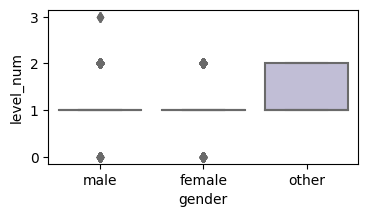

               sum_sq      df          F    PR(>F)
C(gender)    5.521218     2.0  11.110395  0.000016
Residual   658.696190  2651.0        NaN       NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
female   male   0.0848 0.0001   0.038 0.1315   True
female  other   0.3235 0.0422  0.0089  0.638   True
  male  other   0.2387 0.1752 -0.0751 0.5524  False
---------------------------------------------------


In [43]:
df_software['level_num'] = df_software['level'].replace({
    'junior': 0, 
    'no-level': 1,
    'senior': 2, 
    'vip': 3}
)
anova_pairwise_tukeyhsd(df_software, 'edu', 'level_num')
anova_pairwise_tukeyhsd(df_software, 'gender', 'level_num')

#### Tập trung vào nhóm có bằng high school & gender là other làm ngành software
- Ta thấy tỉ trọng level là senior của nhóm có bằng high school cao hơn 35% vs 6.1%
- Lương của 2 nhóm có edu này khá tương đồng, nhưng cũng **không có ý nghĩ về thống kê**, do nhóm hs chiếm qua nhỏ trong tập dữ liệu
- Age mean của nhóm high school là 32, bachelor là khoảng 29.75 qua t-test
- Exp mean của nhóm high school là 9, của bachelor là 5.14  qua t-test
- Tuy nhiên ta cũng cần chú ý tỉ lệ nhưng người có bằng high school trong số những người làm trong ngành software rất thấp
- Những người làm trong software, cấp bậc là high school, gender là other thì 50:50 người đó là middle hoặc senior


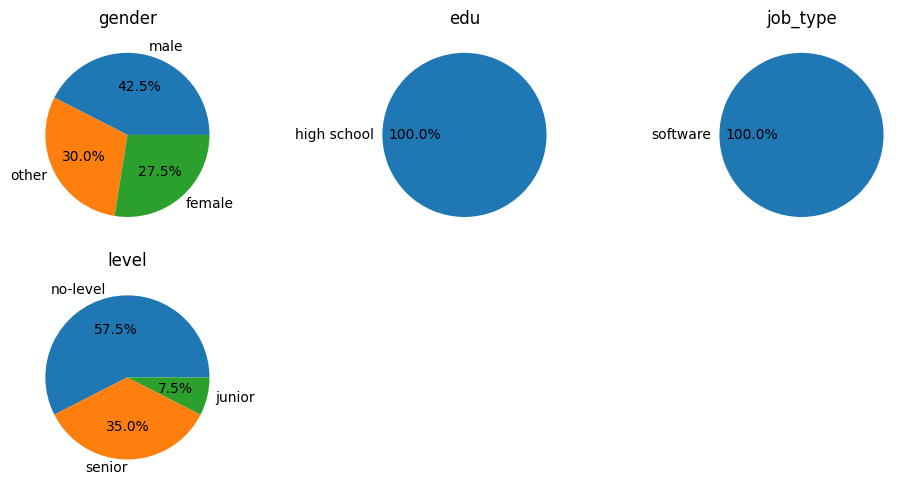

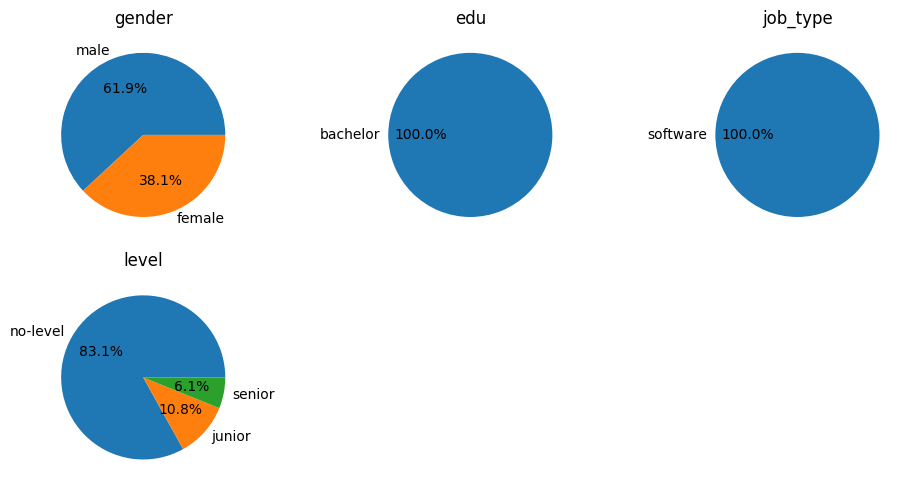

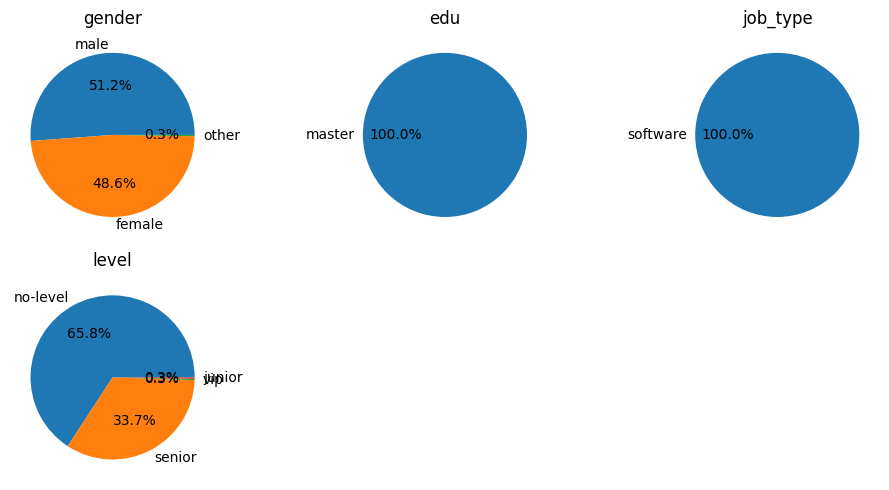

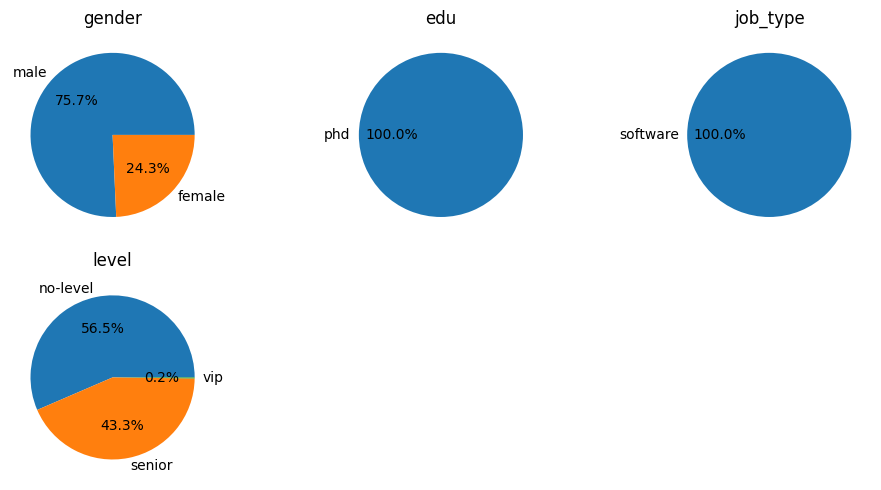

In [52]:
df_software_edu_hs = df_software[df_software['edu'] == 'high school']
df_software_edu_bachelor = df_software[df_software['edu'] == 'bachelor']
df_software_edu_master = df_software[df_software['edu'] == 'master']
df_software_edu_phd = df_software[df_software['edu'] == 'phd']
cat_univariate_analysis(df_software_edu_hs, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.PIE)
cat_univariate_analysis(df_software_edu_bachelor, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.PIE)
cat_univariate_analysis(df_software_edu_master, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.PIE)
cat_univariate_analysis(df_software_edu_phd, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.PIE)


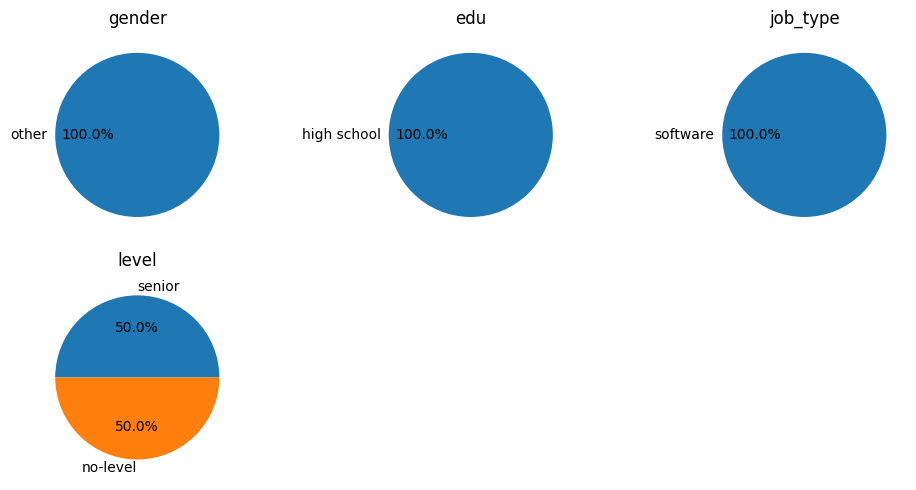

In [53]:
df_software_edu_hs_gender_other = df_software_edu_hs[df_software_edu_hs['gender'] == 'other']
cat_univariate_analysis(df_software_edu_hs_gender_other, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.PIE)

In [51]:
print(f'salary high school: {df_software_edu_hs["salary"].mean()} vs bachelor salary: {df_software_edu_bachelor["salary"].mean()}')
print(ttest_ind(df_software_edu_hs['salary'], df_software_edu_bachelor['salary']))
print('****************************************************')
print(f'age high school: {df_software_edu_hs["age"].mean()} vs bachelor age: {df_software_edu_bachelor["age"].mean()}')
print(ttest_ind(df_software_edu_hs['age'], df_software_edu_bachelor['age']))
print('****************************************************')
print(f'exp high school: {df_software_edu_hs["exp"].mean()} vs bachelor exp: {df_software_edu_bachelor["exp"].mean()}')
print(ttest_ind(df_software_edu_hs['exp'], df_software_edu_bachelor['exp']))

salary high school: 90314.975 vs bachelor salary: 96358.54191176471
Ttest_indResult(statistic=-0.8518954675711664, pvalue=0.3944180185782322)
****************************************************
age high school: 32.125 vs bachelor age: 29.7375
Ttest_indResult(statistic=2.6353877734609257, pvalue=0.008497061326886187)
****************************************************
exp high school: 9.3 vs bachelor exp: 5.141176470588236
Ttest_indResult(statistic=5.076116254574521, pvalue=4.37081998305202e-07)
